# 3) Backtest — Walk-forward Evaluation

Loads saved model and evaluates on the hold-out split using the same minimal env.

In [2]:
# ---- Path & imports ----
import sys, os
sys.path.insert(0, os.path.abspath('..'))  # Path fix

import os, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SB3 algos (multi-algo support)
from stable_baselines3 import PPO, A2C, DQN
ALGO_MAP = {"ppo": PPO, "a2c": A2C, "dqn": DQN}

import gymnasium as gym
from gymnasium import spaces
from dotenv import load_dotenv

import features

# ---- helpers ----
def infer_algo_from_name(p: Path) -> str:
    name = p.stem.lower()
    for k in ALGO_MAP:
        if name.startswith(k + "_"):
            return k
    return "ppo"

def collect_model_candidates(models_dir: Path, symbol: str, timeframe: str, algo: str, explicit: str | None = None):
    # If user explicitly passed a filename, use only that
    if explicit:
        p = Path(explicit)
        if not p.is_absolute():
            p = models_dir / p
        return [p] if p.exists() else []

    cands = []
    if algo in ALGO_MAP:  # specific algo requested
        cands += list(models_dir.glob(f"{algo.lower()}_{symbol}_{timeframe}.zip"))
        # fallback: any file for that algo
        if not cands:
            cands += list(models_dir.glob(f"{algo.lower()}_*.zip"))
    else:
        # auto/all: try perfect matches for all algos first
        for a in ALGO_MAP:
            cands += list(models_dir.glob(f"{a}_{symbol}_{timeframe}.zip"))
        # then looser matches for this symbol/timeframe
        if not cands:
            cands += list(models_dir.glob(f"*_{symbol}_{timeframe}.zip"))
        # finally, anything under models/
        if not cands:
            cands += list(models_dir.glob("*.zip"))

    # de-dup while preserving order
    seen = set()
    out = []
    for p in cands:
        if p not in seen:
            out.append(p)
            seen.add(p)
    return out

# ---- config/env ----
load_dotenv()
SYMBOL = os.getenv("TRAINING_SYMBOL", "EURUSD")
TIMEFRAME = os.getenv("TIMEFRAME", "M15")
SPLIT_RATIO = float(os.getenv("SPLIT_RATIO", "0.8"))
ALGO = os.getenv("ALGO", "auto").lower()        # "auto" | "all" | "ppo" | "a2c" | "dqn"
MODEL_FILE = os.getenv("MODEL_FILE", "").strip()  # optional explicit filename

# ---- paths ----
DATA_CSV = Path("data") / f"ohlc_{SYMBOL}_{TIMEFRAME}.csv"
FEAT_JSON = Path("models") / "selected_features.json"
MODELS_DIR = Path("models")

# ---- resolve models ----
MODEL_PATHS = collect_model_candidates(MODELS_DIR, SYMBOL, TIMEFRAME, ALGO, explicit=MODEL_FILE)
assert DATA_CSV.exists(), "Data CSV missing. Run 1_Data.ipynb"
assert FEAT_JSON.exists(), "selected_features.json missing. Run 2_Train.ipynb"
assert MODEL_PATHS, (
    f"No model zips found in {MODELS_DIR}/ for {SYMBOL} {TIMEFRAME}. "
    f"Train first, or set MODEL_FILE env to a specific zip."
)

# Build (path, algo) bundle and pick a default for legacy cells
MODEL_BUNDLE = [(p, infer_algo_from_name(p)) for p in MODEL_PATHS]
MODEL_PATH, ALGO_SELECTED = MODEL_BUNDLE[0]

# ---- report ----
print(f"Found {len(MODEL_BUNDLE)} model(s):")
for p, a in MODEL_BUNDLE:
    print(f" - {p.name}  (algo={a.upper()})")
print(f"\nDefault selected for single-model cells: {MODEL_PATH.name} | algo={ALGO_SELECTED.upper()}")

# ---- load data & features ----
df = pd.read_csv(DATA_CSV, parse_dates=["time"], index_col="time")
df_feat = features.add_indicators(df.copy())
with open(FEAT_JSON, "r", encoding="utf-8") as f:
    feature_cols = json.load(f)

# test split
n_split = int(len(df_feat) * SPLIT_RATIO)
df_test = df_feat.iloc[n_split:].copy()
print("Test set:", df_test.shape)


Found 3 model(s):
 - ppo_EURUSD_M15.zip  (algo=PPO)
 - a2c_EURUSD_M15.zip  (algo=A2C)
 - dqn_EURUSD_M15.zip  (algo=DQN)

Default selected for single-model cells: ppo_EURUSD_M15.zip | algo=PPO
Test set: (9958, 17)


In [3]:
# same env as training (mapping: 0=SELL, 1=HOLD, 2=BUY)
class TradingEnv(gym.Env):
    """
    Discrete(3) trading environment:
      action 0 -> position -1 (SELL)
      action 1 -> position  0 (HOLD/FLAT)
      action 2 -> position +1 (BUY)
    Reward = position * return - trade_cost_on_switch
    """
    metadata = {"render_modes": []}

    def __init__(self, df_feat, feature_cols, trade_cost=1e-4):
        super().__init__()
        import numpy as np
        from gymnasium import spaces

        self.df = df_feat
        self.cols = feature_cols
        self.trade_cost = float(trade_cost)

        self.n = len(self.df)
        self.idx = 0
        self.position = 0

        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(len(self.cols),), dtype=np.float32
        )
        self.action_space = spaces.Discrete(3)

        # explicit mapping to avoid ambiguity
        self.ACTION_TO_POS = {0: -1, 1: 0, 2: 1}

    def _obs(self):
        row = self.df.iloc[self.idx][self.cols].astype(float).values
        return row.astype(np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        # start at 1 so we can compute ret using idx-1
        self.idx = 1
        self.position = 0
        return self._obs(), {}

    def step(self, action):
        # map action to target position
        pos_new = self.ACTION_TO_POS.get(int(action), 0)

        prev = float(self.df["close"].iloc[self.idx - 1])
        curr = float(self.df["close"].iloc[self.idx])
        ret = (curr - prev) / (prev + 1e-12)

        # apply cost only when we change position
        cost = self.trade_cost if pos_new != self.position else 0.0
        reward = pos_new * ret - cost

        # advance state
        self.position = pos_new
        self.idx += 1
        truncated = self.idx >= (self.n - 1)

        return self._obs(), float(reward), False, truncated, {
            "ret": ret,
            "position": self.position
        }



=== Backtesting ppo_EURUSD_M15.zip (algo=PPO) ===
Sharpe (rough): 0.897  |  MaxDD: -3.73%


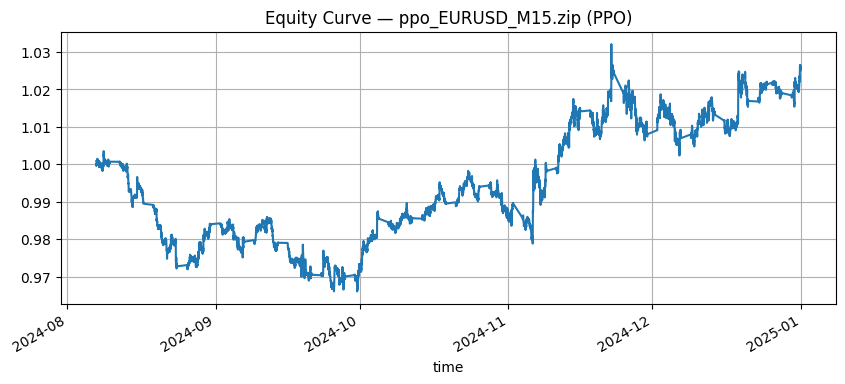


=== Backtesting a2c_EURUSD_M15.zip (algo=A2C) ===
Sharpe (rough): -1.843  |  MaxDD: -7.80%


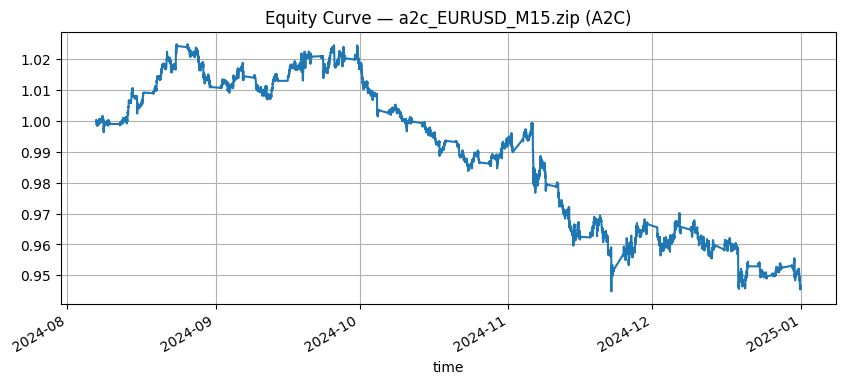


=== Backtesting dqn_EURUSD_M15.zip (algo=DQN) ===
Sharpe (rough): -11.667  |  MaxDD: -29.24%


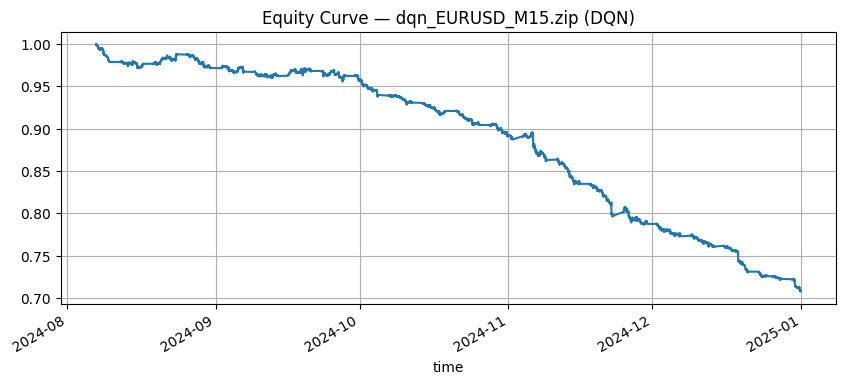


Leaderboard (by Sharpe):


,model,algo,sharpe,max_drawdown,steps
0,ppo_EURUSD_M15.zip,ppo,0.896809,-0.037317,9956
1,a2c_EURUSD_M15.zip,a2c,-1.843478,-0.077969,9956
2,dqn_EURUSD_M15.zip,dqn,-11.667301,-0.292419,9956


In [4]:
# ---- Multi-model backtest (loops over all discovered models) ----
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import PPO, A2C, DQN

ALGO_MAP = {"ppo": PPO, "a2c": A2C, "dqn": DQN}

# Fallbacks if previous cell didn't define helpers/vars
def _infer_algo_from_name(p: Path) -> str:
    name = p.stem.lower()
    for k in ALGO_MAP:
        if name.startswith(k + "_"):
            return k
    return "ppo"

if 'MODEL_BUNDLE' not in globals():
    # try single-model fallback
    if 'MODEL_PATH' in globals():
        MODEL_BUNDLE = [(Path(MODEL_PATH), _infer_algo_from_name(Path(MODEL_PATH)))]
    else:
        raise RuntimeError("No models found: define MODEL_BUNDLE or MODEL_PATH first.")

def _bars_per_year(tf: str) -> float:
    tf = str(tf).upper()
    if tf.startswith("M"):
        m = int(tf[1:])
        bpd = 24*60/m
    elif tf.startswith("H"):
        m = int(tf[1:]) * 60
        bpd = 24*60/m
    elif tf in ("D1", "1D"):
        bpd = 1
    else:
        bpd = 24*4  # ~M15 default
    return bpd * 252.0

tf_str = TIMEFRAME if isinstance(TIMEFRAME, str) else "M15"
ann_factor = _bars_per_year(tf_str)

results = []  # collect per-model metrics

for model_path, algo in MODEL_BUNDLE:
    algo = algo.lower()
    if algo not in ALGO_MAP:
        print(f"Skipping {model_path.name}: unsupported algo '{algo}'")
        continue

    print(f"\n=== Backtesting {model_path.name} (algo={algo.upper()}) ===")
    model = ALGO_MAP[algo].load(model_path.as_posix())

    env = TradingEnv(df_test, feature_cols)
    obs, _ = env.reset()
    equity = [1.0]
    rets = []

    while True:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(int(action))
        equity.append(equity[-1] * (1.0 + reward))
        rets.append(info.get("ret", reward))
        if terminated or truncated:
            break

    equity = pd.Series(equity, index=df_test.index[:len(equity)])
    returns = equity.pct_change().dropna()
    sharpe = float((returns.mean() / (returns.std() + 1e-12)) * np.sqrt(ann_factor))
    dd = (equity / equity.cummax() - 1.0)
    mdd = float(dd.min())

    print(f"Sharpe (rough): {sharpe:.3f}  |  MaxDD: {mdd:.2%}")

    # Save metrics row
    results.append({
        "model": model_path.name,
        "algo": algo,
        "sharpe": sharpe,
        "max_drawdown": mdd,
        "steps": len(returns)
    })

    # Plot equity per model (separate figure each to keep it clear)
    plt.figure(figsize=(10,4))
    equity.plot(title=f"Equity Curve — {model_path.name} ({algo.upper()})")
    plt.grid(True)
    plt.show()

# Optional: show a small leaderboard
if results:
    leaderboard = pd.DataFrame(results).sort_values("sharpe", ascending=False)
    print("\nLeaderboard (by Sharpe):")
    display(leaderboard)


# Enriched Evaluation & Plots

Adds action distribution, equity vs buy & hold, underwater (drawdown), rolling Sharpe, monthly returns, and optional QuantStats export.


================ ppo_EURUSD_M15.zip | PPO ================
bars            9956.000000
Sharpe             0.896809
Sortino            1.245242
CAGR               0.065507
Calmar             1.755408
MaxDD             -0.037317
WinRate            0.476195
ProfitFactor       1.018795
Exposure           0.995078
Trades           238.000000
AvgHoldBars      847.694255
dtype: float64


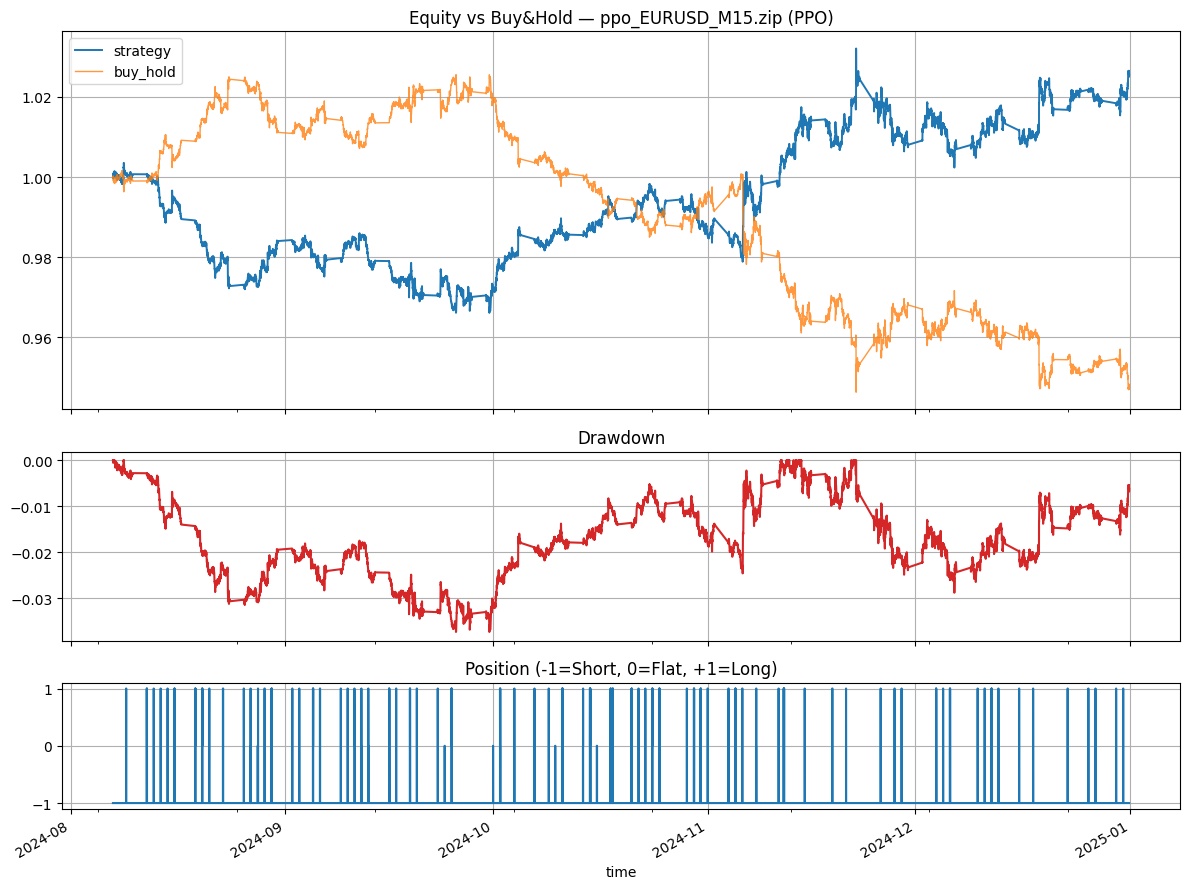

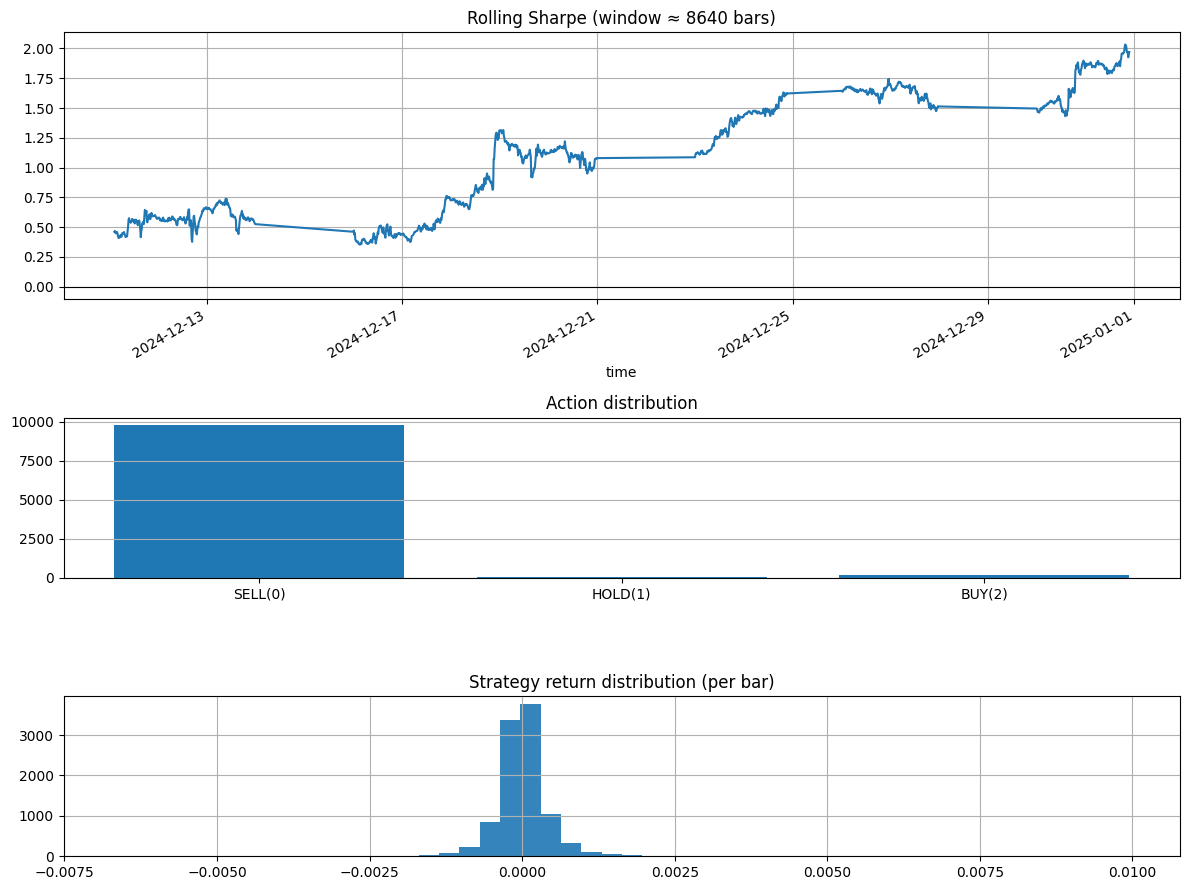


================ a2c_EURUSD_M15.zip | A2C ================
bars            9956.000000
Sharpe            -1.843478
Sortino           -2.168042
CAGR              -0.128641
Calmar            -1.649887
MaxDD             -0.077969
WinRate            0.498393
ProfitFactor       0.962365
Exposure           0.999196
Trades            14.000000
AvgHoldBars     2746.865810
dtype: float64


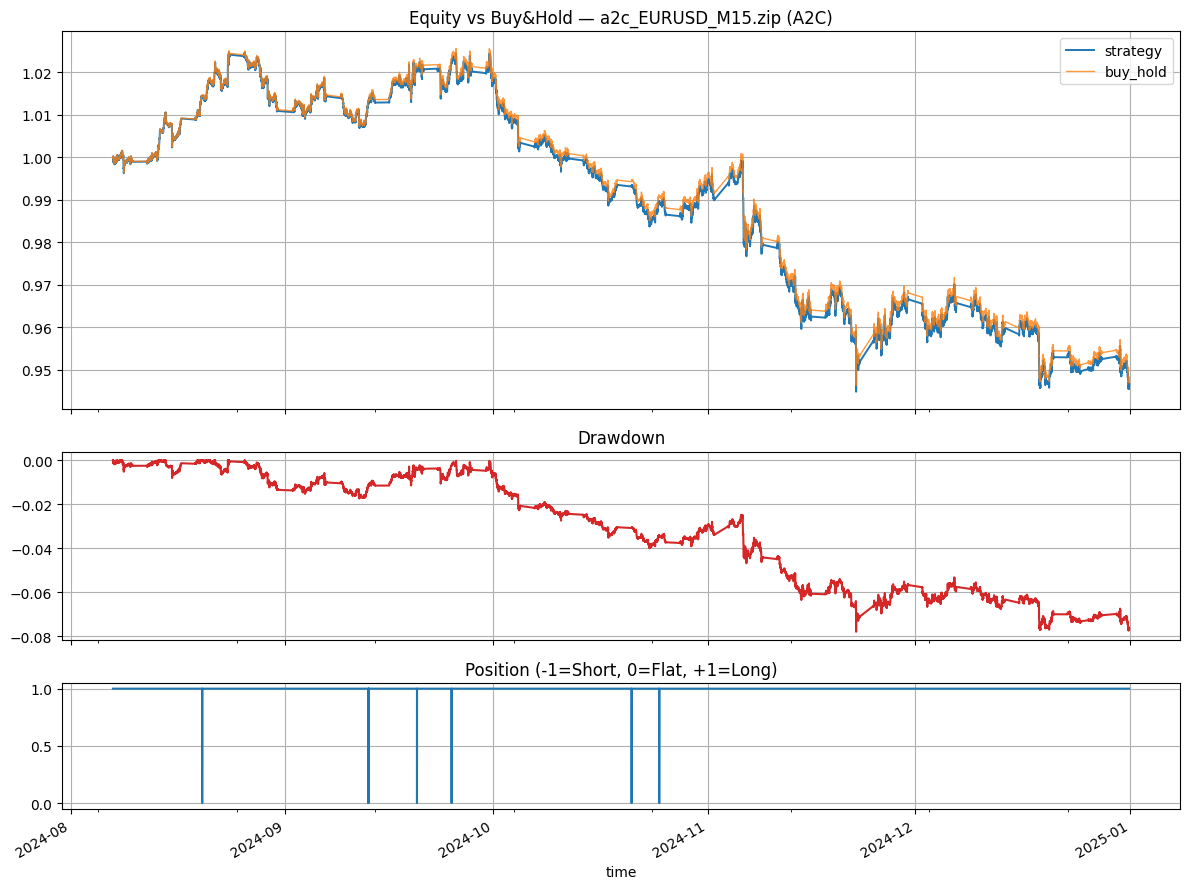

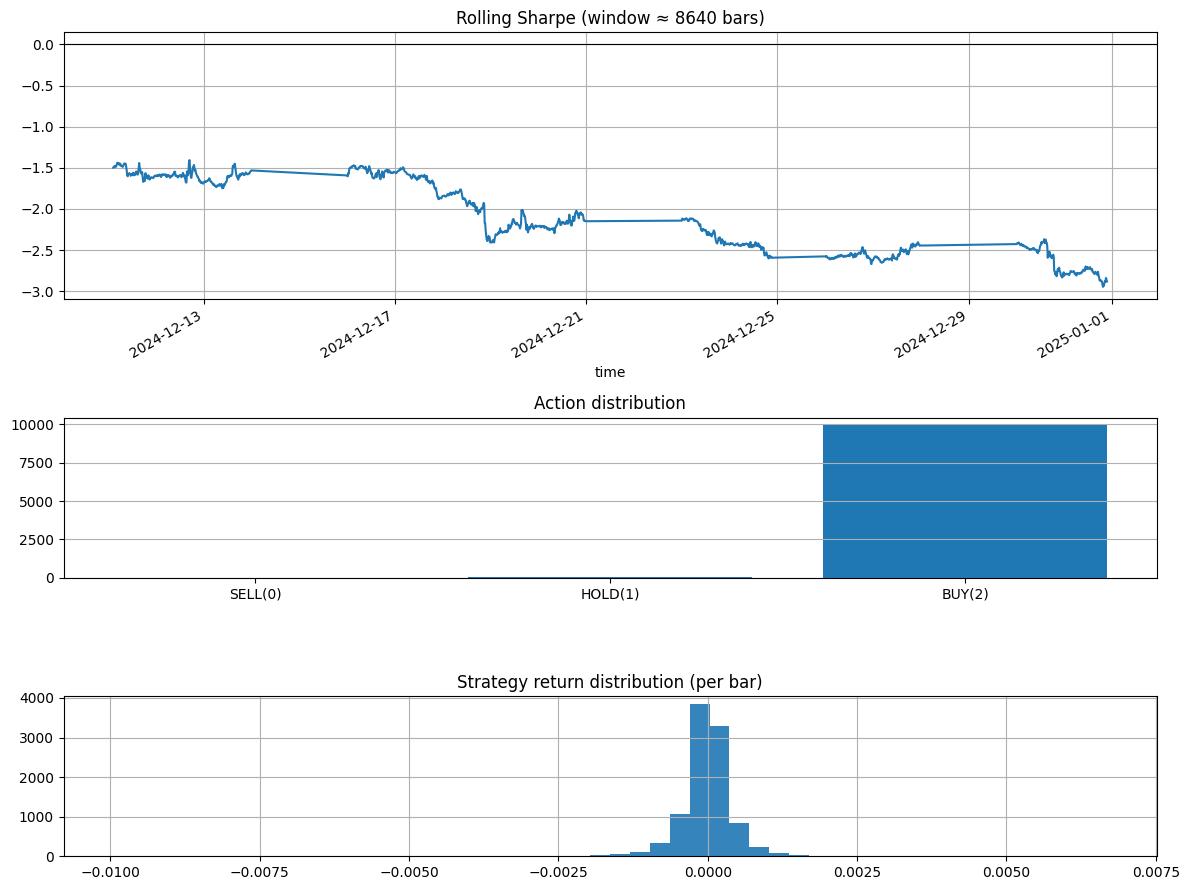


================ dqn_EURUSD_M15.zip | DQN ================
bars            9956.000000
Sharpe           -11.667301
Sortino          -12.971816
CAGR              -0.578343
Calmar            -1.977823
MaxDD             -0.292414
WinRate            0.465448
ProfitFactor       0.783297
Exposure           0.983126
Trades          1050.000000
AvgHoldBars      666.864403
dtype: float64


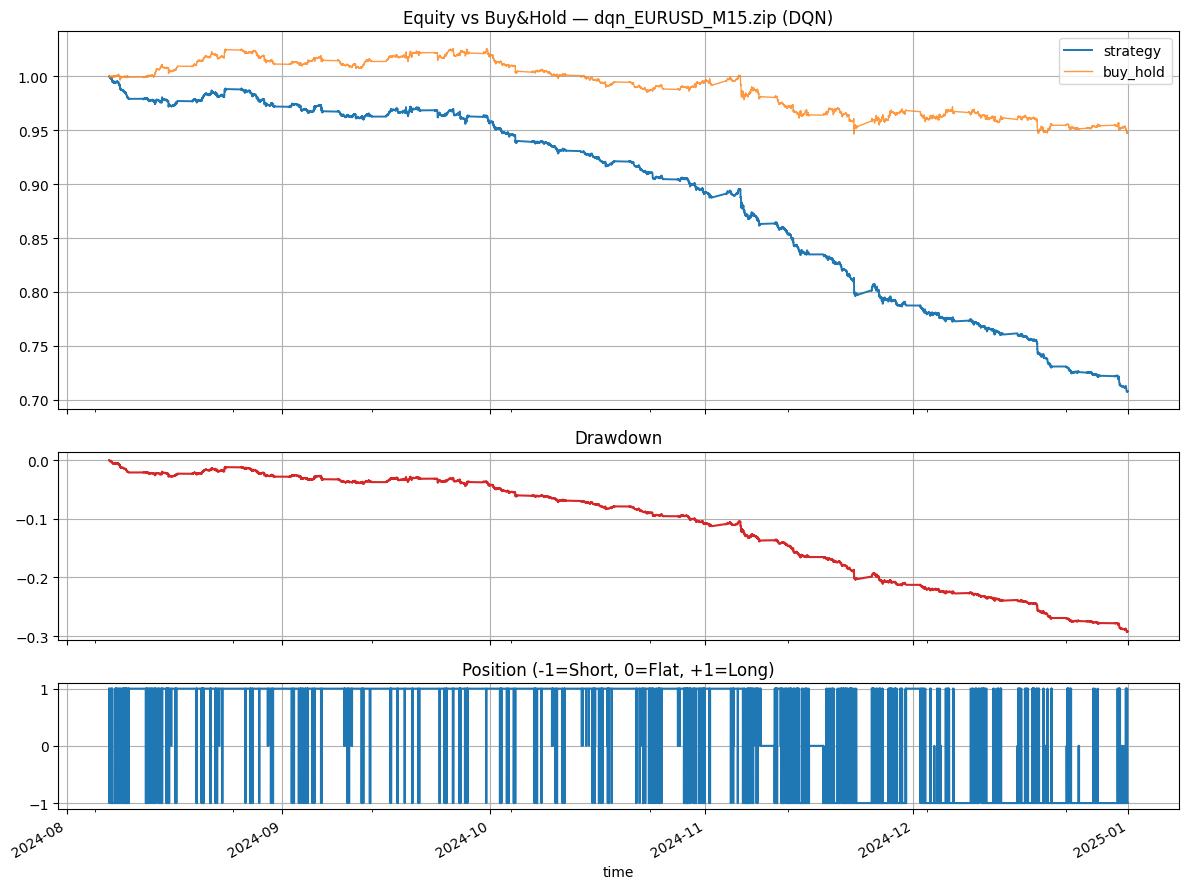

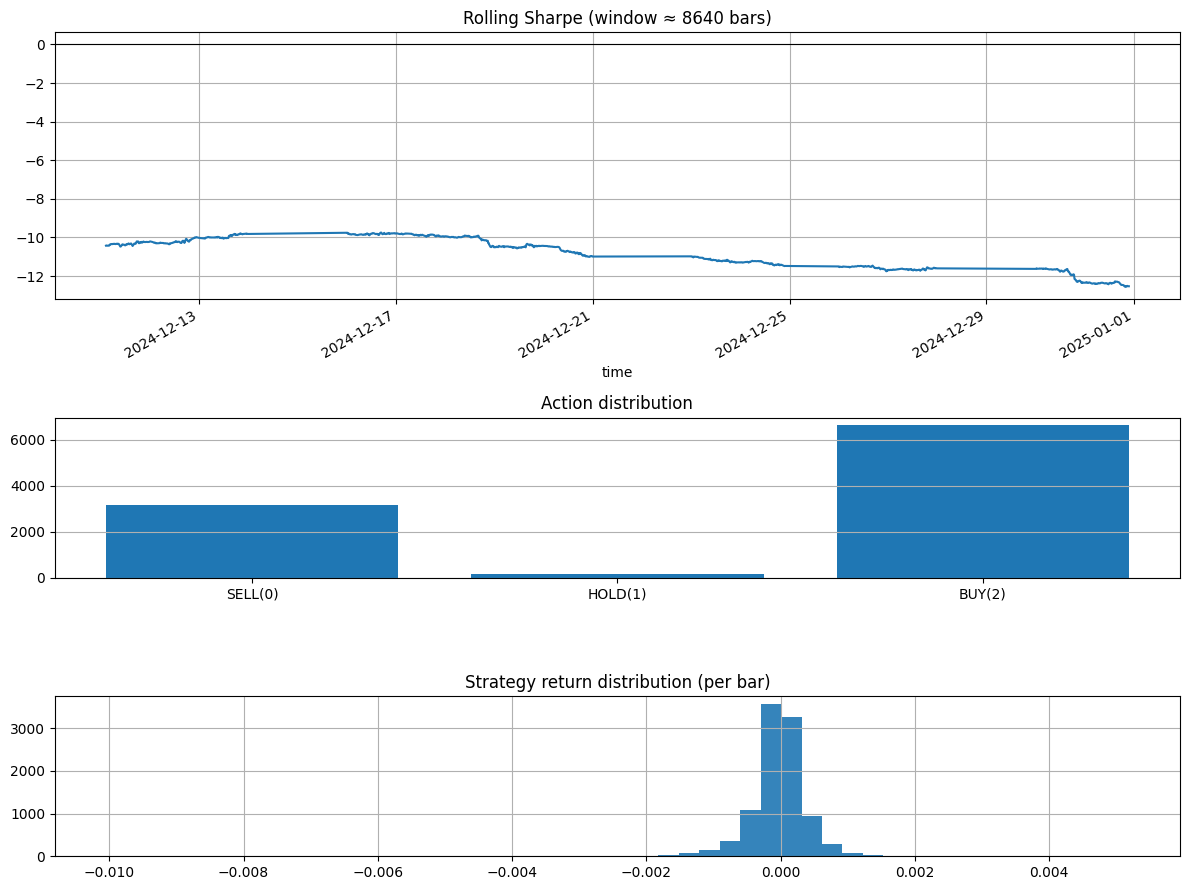


Leaderboard (sorted by Sharpe, then Calmar):


,model,algo,Sharpe,Sortino,CAGR,Calmar,MaxDD,WinRate,ProfitFactor,Exposure,Trades,AvgHoldBars
0,ppo_EURUSD_M15.zip,ppo,0.896809,1.245242,0.065507,1.755408,-0.037317,0.476195,1.018795,0.995078,238,847.694255
1,a2c_EURUSD_M15.zip,a2c,-1.843478,-2.168042,-0.128641,-1.649887,-0.077969,0.498393,0.962365,0.999196,14,2746.865810
2,dqn_EURUSD_M15.zip,dqn,-11.667301,-12.971816,-0.578343,-1.977823,-0.292414,0.465448,0.783297,0.983126,1050,666.864403


Saved metrics to: G:\My Drive\Bots DRL\DRL\DRL-MT5-Lab\notebooks\models\metrics_EURUSD_M15.csv


In [4]:
# === Enriched evaluation & plots for ALL models (PPO/A2C/DQN) ===
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# SB3 loaders (in case not imported above)
from stable_baselines3 import PPO, A2C, DQN
ALGO_MAP = {"ppo": PPO, "a2c": A2C, "dqn": DQN}

# Fallback to single model if bundle not provided
def _infer_algo_from_name(p: Path) -> str:
    name = p.stem.lower()
    for k in ALGO_MAP:
        if name.startswith(k + "_"):
            return k
    return "ppo"

if 'MODEL_BUNDLE' not in globals():
    if 'MODEL_PATH' in globals():
        MODEL_BUNDLE = [(Path(MODEL_PATH), _infer_algo_from_name(Path(MODEL_PATH)))]
    else:
        raise RuntimeError("No models found: define MODEL_BUNDLE or MODEL_PATH first.")

def bars_per_day(tf: str) -> int:
    tf = str(tf).upper()
    if tf.startswith("M"):
        try:
            m = int(tf[1:])
            return int((24*60)/m)
        except Exception:
            return 96
    if tf.startswith("H"):
        try:
            h = int(tf[1:])
            return int(24/h)
        except Exception:
            return 24
    if tf in ("D1", "1D"):
        return 1
    return 96  # default ≈ M15

def ann_factor(tf: str) -> float:
    return np.sqrt(252 * bars_per_day(tf))

def CAGR(eq: pd.Series) -> float:
    if len(eq) < 2:
        return np.nan
    total = float(eq.iloc[-1]) / float(eq.iloc[0])
    yrs = (eq.index[-1] - eq.index[0]).days / 365.25
    return (total ** (1/max(yrs, 1e-9))) - 1.0

def compute_metrics(equity: pd.Series, strat_rets: pd.Series, raw_rets: pd.Series, timeframe: str, positions: pd.Series, actions: pd.Series) -> dict:
    ann = ann_factor(timeframe)
    sharpe = float((strat_rets.mean() / (strat_rets.std() + 1e-12)) * ann)
    downside = strat_rets[strat_rets < 0]
    sortino = float((strat_rets.mean() / (downside.std() + 1e-12)) * ann)
    cummax = equity.cummax()
    dd = equity / cummax - 1.0
    mdd = float(dd.min())
    cagr = CAGR(equity)
    calmar = float(cagr / (abs(mdd) + 1e-12))
    win_rate = float((strat_rets > 0).mean())
    pf = float(strat_rets[strat_rets > 0].sum() / (abs(strat_rets[strat_rets < 0].sum()) + 1e-12))
    exposure = float((positions != 0).mean())
    # trades = number of position changes (ignore first)
    trades = int((positions.diff().fillna(0) != 0).sum())
    avg_hold = float((positions != 0).astype(int).groupby((positions == 0).astype(int).cumsum()).transform('size').mean()) if trades > 0 else np.nan
    return {
        "Sharpe": sharpe,
        "Sortino": sortino,
        "CAGR": cagr,
        "Calmar": calmar,
        "MaxDD": mdd,
        "WinRate": win_rate,
        "ProfitFactor": pf,
        "Exposure": exposure,
        "Trades": trades,
        "AvgHoldBars": avg_hold
    }

results = []
tf_str = TIMEFRAME if isinstance(TIMEFRAME, str) else "M15"
BPD = bars_per_day(tf_str)

for model_path, algo in MODEL_BUNDLE:
    algo = algo.lower()
    if algo not in ALGO_MAP:
        print(f"Skipping {model_path.name}: unsupported algo '{algo}'")
        continue

    print(f"\n================ {model_path.name} | {algo.upper()} ================")
    model = ALGO_MAP[algo].load(Path(model_path).as_posix())

    env = TradingEnv(df_test, feature_cols)
    obs, _ = env.reset()

    equity_vals = [1.0]
    rewards = []
    raw_rets = []
    positions = []
    actions = []

    while True:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(int(action))
        equity_vals.append(equity_vals[-1] * (1.0 + reward))
        rewards.append(float(reward))
        raw_rets.append(float(info.get("ret", 0.0)))
        positions.append(int(info.get("position", 0)))
        actions.append(int(action))
        if terminated or truncated:
            break

    # Align per-step series with the time index
    idx = df_test.index[1:1+len(rewards)]
    strat_rets = pd.Series(rewards, index=idx, name="strategy_ret")
    equity = pd.Series(equity_vals[1:], index=idx, name="equity")
    pos_series = pd.Series(positions, index=idx, name="position")
    action_series = pd.Series(actions, index=idx, name="action")
    bh = pd.Series((1.0 + pd.Series(raw_rets, index=idx)).cumprod(), name="buy_hold")

    # Metrics
    m = compute_metrics(equity, strat_rets, pd.Series(raw_rets, index=idx), tf_str, pos_series, action_series)
    summary = pd.Series({
        "bars": len(strat_rets),
        **{k: (round(v, 6) if isinstance(v, float) else v) for k, v in m.items()}
    })
    print(summary)

    # ====== Plots (2 figures per model) ======
    # Fig 1: Equity vs Buy&Hold + Drawdown + Position
    fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True, gridspec_kw={"height_ratios": [3, 1.5, 1]})
    (equity.rename("strategy")).plot(ax=axes[0], lw=1.4)
    bh.plot(ax=axes[0], lw=1.0, alpha=0.8)
    axes[0].set_title(f"Equity vs Buy&Hold — {model_path.name} ({algo.upper()})")
    axes[0].legend()
    axes[0].grid(True)

    dd = equity / equity.cummax() - 1.0
    dd.plot(ax=axes[1], color="tab:red")
    axes[1].set_title("Drawdown")
    axes[1].grid(True)

    pos_series.plot(ax=axes[2], drawstyle="steps-post")
    axes[2].set_title("Position (-1=Short, 0=Flat, +1=Long)")
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

    # Fig 2: Rolling Sharpe + Action distribution + Return histogram
    fig, axes = plt.subplots(3, 1, figsize=(12, 9), gridspec_kw={"height_ratios": [2, 1.2, 1.2]})
    roll_win = max(30, int(90 * BPD))  # ~90 days in bars (min 30)
    rmean = strat_rets.rolling(roll_win).mean()
    rstd = strat_rets.rolling(roll_win).std()
    rsharpe = rmean / (rstd + 1e-12) * np.sqrt(252 * BPD)
    rsharpe.plot(ax=axes[0])
    axes[0].axhline(0, color="k", lw=0.8)
    axes[0].set_title(f"Rolling Sharpe (window ≈ {roll_win} bars)")
    axes[0].grid(True)

    cnt = Counter(action_series.values)  # 0=SELL, 1=HOLD, 2=BUY
    axes[1].bar(["SELL(0)", "HOLD(1)", "BUY(2)"], [cnt.get(0,0), cnt.get(1,0), cnt.get(2,0)])
    axes[1].set_title("Action distribution")
    axes[1].grid(True, axis="y")

    axes[2].hist(strat_rets.values, bins=50, alpha=0.9)
    axes[2].set_title("Strategy return distribution (per bar)")
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

    # Collect to leaderboard
    results.append({
        "model": model_path.name,
        "algo": algo,
        **m
    })

# ===== Leaderboard across models =====
if results:
    leaderboard = pd.DataFrame(results).sort_values(["Sharpe", "Calmar"], ascending=False)
    print("\nLeaderboard (sorted by Sharpe, then Calmar):")
    display(leaderboard)

    # Optional: save metrics table
    out_csv = Path("models") / f"metrics_{SYMBOL}_{tf_str}.csv"
    leaderboard.to_csv(out_csv, index=False)
    print("Saved metrics to:", out_csv.resolve())


In [5]:
# --- Action distribution & monthly returns (for ALL models) ---
from pathlib import Path
import numpy as np
import pandas as pd
from stable_baselines3 import PPO, A2C, DQN

ALGO_MAP = {"ppo": PPO, "a2c": A2C, "dqn": DQN}

# Fallback if only single model provided
def _infer_algo_from_name(p: Path) -> str:
    name = p.stem.lower()
    for k in ALGO_MAP:
        if name.startswith(k + "_"):
            return k
    return "ppo"

if 'MODEL_BUNDLE' not in globals():
    if 'MODEL_PATH' in globals():
        MODEL_BUNDLE = [(Path(MODEL_PATH), _infer_algo_from_name(Path(MODEL_PATH)))]
    else:
        raise RuntimeError("No models found: define MODEL_BUNDLE or MODEL_PATH first.")

all_monthly = []

for model_path, algo in MODEL_BUNDLE:
    algo = algo.lower()
    if algo not in ALGO_MAP:
        print(f"Skipping {model_path.name}: unsupported algo '{algo}'")
        continue

    print(f"\n=== {model_path.name} | {algo.upper()} ===")
    model = ALGO_MAP[algo].load(Path(model_path).as_posix())

    # Run once to get actions & returns
    env = TradingEnv(df_test, feature_cols)
    obs, _ = env.reset()
    rewards, actions = [], []

    while True:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(int(action))
        rewards.append(float(reward))
        actions.append(int(action))
        if terminated or truncated:
            break

    idx = df_test.index[1:1+len(rewards)]
    strat_rets = pd.Series(rewards, index=idx, name="strategy_ret")
    action_series = pd.Series(actions, index=idx, name="action")

    # Action distribution (0=Sell, 1=Hold, 2=Buy)
    action_map = {0: "Sell", 1: "Hold", 2: "Buy"}
    action_counts = action_series.map(action_map).value_counts()
    print("Action counts:\n", action_counts)

    # Monthly compounded returns
    monthly = strat_rets.resample("M").apply(lambda x: (1 + x).prod() - 1.0)
    monthly.name = model_path.stem  # column label in merged table
    all_monthly.append(monthly)

# Merge monthly across models, show last 12 rows
if all_monthly:
    monthly_df = pd.concat(all_monthly, axis=1)
    monthly_df.index = monthly_df.index.to_period("M")
    try:
        display(monthly_df.tail(12).style.format("{:.2%}").set_caption("Monthly compounded returns (last 12)"))
    except Exception:
        print("\nMonthly compounded returns (last 12):")
        print(monthly_df.tail(12).applymap(lambda v: f"{v:.2%}"))

    # Optional: save to CSV
    out_csv = Path("models") / f"monthly_{SYMBOL}_{TIMEFRAME}.csv"
    monthly_df.to_csv(out_csv, float_format="%.6f")
    print("Saved monthly returns to:", out_csv.resolve())



=== ppo_EURUSD_M15.zip | PPO ===
Action counts:
 action
Sell    9766
Buy      141
Hold      49
Name: count, dtype: int64

=== a2c_EURUSD_M15.zip | A2C ===


C:\Users\moham\AppData\Local\Temp\ipykernel_31600\2918636110.py:57: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = strat_rets.resample("M").apply(lambda x: (1 + x).prod() - 1.0)


Action counts:
 action
Buy     9948
Hold       8
Name: count, dtype: int64

=== dqn_EURUSD_M15.zip | DQN ===


C:\Users\moham\AppData\Local\Temp\ipykernel_31600\2918636110.py:57: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = strat_rets.resample("M").apply(lambda x: (1 + x).prod() - 1.0)


Action counts:
 action
Buy     6627
Sell    3161
Hold     168
Name: count, dtype: int64


C:\Users\moham\AppData\Local\Temp\ipykernel_31600\2918636110.py:57: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = strat_rets.resample("M").apply(lambda x: (1 + x).prod() - 1.0)
C:\Users\moham\AppData\Local\Temp\ipykernel_31600\2918636110.py:64: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_df.index = monthly_df.index.to_period("M")


,ppo_EURUSD_M15,a2c_EURUSD_M15,dqn_EURUSD_M15
time,,,
2024-08,-1.60%,1.09%,-2.82%
2024-09,-1.20%,0.70%,-1.49%
2024-10,1.37%,-2.30%,-6.79%
2024-11,2.29%,-2.81%,-11.74%
2024-12,1.74%,-2.09%,-10.10%


Saved monthly returns to: G:\My Drive\Bots DRL\DRL\DRL-MT5-Lab\notebooks\models\monthly_EURUSD_M15.csv


In [7]:
# === QuantStats HTML reports (daily) for ALL models — robust tz handling ===
from pathlib import Path
import numpy as np
import pandas as pd
from stable_baselines3 import PPO, A2C, DQN

ALGO_MAP = {"ppo": PPO, "a2c": A2C, "dqn": DQN}

def _infer_algo_from_name(p: Path) -> str:
    name = p.stem.lower()
    for k in ALGO_MAP:
        if name.startswith(k + "_"):
            return k
    return "ppo"

# Fallback to single model if bundle missing
if 'MODEL_BUNDLE' not in globals():
    if 'MODEL_PATH' in globals():
        MODEL_BUNDLE = [(Path(MODEL_PATH), _infer_algo_from_name(Path(MODEL_PATH)))]
    else:
        raise RuntimeError("No models found: define MODEL_BUNDLE or MODEL_PATH first.")

def _to_naive_index(s: pd.Series) -> pd.Series:
    """Ensure DatetimeIndex is tz-naive (drop tz)."""
    s = s.copy()
    if isinstance(s.index, pd.DatetimeIndex) and s.index.tz is not None:
        # if you want to preserve absolute UTC moments, convert to UTC first, then drop tz
        s.index = s.index.tz_convert("UTC").tz_localize(None)
    return s

def _daily_compounded(returns_bar: pd.Series) -> pd.Series:
    """Compound intrabar returns to daily returns and drop NaNs."""
    s = _to_naive_index(returns_bar.sort_index())
    return s.resample("1D").apply(lambda x: (1 + x).prod() - 1.0).dropna()

try:
    import quantstats as qs
    qs.extend_pandas()
except Exception as e:
    print("QuantStats not available or failed to import:", e)
    print("Tip: pip install quantstats")
else:
    INCLUDE_BENCHMARK = True  # set False if you want to skip benchmark to avoid alignment issues
    out_dir = Path("reports"); out_dir.mkdir(exist_ok=True)
    links = []

    for model_path, algo in MODEL_BUNDLE:
        algo = algo.lower()
        if algo not in ALGO_MAP:
            print(f"Skipping {model_path.name}: unsupported algo '{algo}'")
            continue

        print(f"\n=== Building QuantStats report for {model_path.name} ({algo.upper()}) ===")
        model = ALGO_MAP[algo].load(model_path.as_posix())

        # Run evaluation pass to collect per-bar strategy returns and raw returns
        env = TradingEnv(df_test, feature_cols)
        obs, _ = env.reset()
        rewards, raw_rets = [], []

        while True:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(int(action))
            rewards.append(float(reward))
            raw_rets.append(float(info.get("ret", 0.0)))
            if terminated or truncated:
                break

        # Build indexed series
        idx = df_test.index[1:1+len(rewards)]
        strat_rets = pd.Series(rewards, index=idx, name="strategy_ret")
        bh_rets    = pd.Series(raw_rets, index=idx, name="bh_ret")

        # Make both tz-naive BEFORE resampling
        strat_rets = _to_naive_index(strat_rets)
        bh_rets    = _to_naive_index(bh_rets)

        # Daily compounded
        daily_strat = _daily_compounded(strat_rets)
        daily_bh    = _daily_compounded(bh_rets)

        # Align indexes (important when passing a benchmark)
        if INCLUDE_BENCHMARK and len(daily_bh):
            common = daily_strat.index.intersection(daily_bh.index)
            daily_strat = daily_strat.reindex(common).dropna()
            daily_bh    = daily_bh.reindex(common).dropna()
            benchmark = daily_bh if len(daily_bh) else None
        else:
            benchmark = None

        # Debug (you can comment these out later)
        # print("strat tz:", getattr(daily_strat.index, "tz", None), "| bh tz:", getattr(daily_bh.index, "tz", None))
        # print("strat idx dtype:", daily_strat.index.dtype, "| bh idx dtype:", daily_bh.index.dtype)

        out_html = out_dir / f"qs_{model_path.stem}.html"
        title = f"DRL-MT5 — {SYMBOL} {TIMEFRAME} — {model_path.stem}"
        try:
            qs.reports.html(daily_strat, benchmark=benchmark, output=out_html.as_posix(), title=title)
            print("Saved QuantStats report to:", out_html.resolve())
            links.append(out_html.name)
        except Exception as e:
            # As a fallback, try again without a benchmark if tz/type alignment still trips
            print(f"QuantStats with benchmark failed: {e}")
            try:
                qs.reports.html(daily_strat, output=out_html.as_posix(), title=title)
                print("Saved QuantStats report (no benchmark) to:", out_html.resolve())
                links.append(out_html.name)
            except Exception as e2:
                print(f"QuantStats report failed for {model_path.name}:", e2)

    # Index page with links
    if links:
        index_path = out_dir / "index.html"
        html = "<h2>QuantStats Reports</h2><ul>" + "".join([f'<li><a href="{name}">{name}</a></li>' for name in links]) + "</ul>"
        index_path.write_text(html, encoding="utf-8")
        print("Wrote report index:", index_path.resolve())



=== Building QuantStats report for ppo_EURUSD_M15.zip (PPO) ===
Saved QuantStats report to: G:\My Drive\Bots DRL\DRL\DRL-MT5-Lab\notebooks\reports\qs_ppo_EURUSD_M15.html

=== Building QuantStats report for a2c_EURUSD_M15.zip (A2C) ===
Saved QuantStats report to: G:\My Drive\Bots DRL\DRL\DRL-MT5-Lab\notebooks\reports\qs_a2c_EURUSD_M15.html

=== Building QuantStats report for dqn_EURUSD_M15.zip (DQN) ===
Saved QuantStats report to: G:\My Drive\Bots DRL\DRL\DRL-MT5-Lab\notebooks\reports\qs_dqn_EURUSD_M15.html
Wrote report index: G:\My Drive\Bots DRL\DRL\DRL-MT5-Lab\notebooks\reports\index.html


In [15]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np, pandas as pd
from pathlib import Path

def _to_naive_index_any(x):
    """TZ-normalize Series/DataFrame."""
    if isinstance(x, (pd.Series, pd.DataFrame)):
        idx = x.index
        if isinstance(idx, pd.DatetimeIndex) and idx.tz is not None:
            x = x.copy()
            x.index = idx.tz_convert("UTC").tz_localize(None)
    return x

def _align_on_common_index(series_list):
    """Return copies aligned on the intersection of all non-empty indices."""
    s_ok = [s for s in series_list if s is not None and len(s) > 0]
    if not s_ok:
        return series_list, pd.DatetimeIndex([])
    common = s_ok[0].index
    for s in s_ok[1:]:
        common = common.intersection(s.index)
    aligned = []
    for s in series_list:
        if s is None or len(s) == 0:
            aligned.append(s)
        else:
            aligned.append(s.reindex(common))
    return aligned, common

def build_plotly_dashboard(df_with_close, pos_series, strat_rets, raw_rets,
                           model_name, algo, symbol, timeframe, out_dir="reports/plotly"):
    """
    Create interactive dashboard:
      row1: Close + entries/exits
      row2: Equity vs Buy&Hold
      row3: Drawdown + Position (secondary axis)
    """
    # 1) tz -> naive BEFORE any reindexing
    pos_series = _to_naive_index_any(pos_series.sort_index())
    strat_rets = _to_naive_index_any(strat_rets.sort_index())
    raw_rets   = _to_naive_index_any(raw_rets.sort_index())
    df_with_close = _to_naive_index_any(df_with_close)

    # 2) align all on common index
    (pos_series, strat_rets, raw_rets), idx = _align_on_common_index([pos_series, strat_rets, raw_rets])

    # Guard: if nothing overlaps, bail early with a friendly message
    if len(idx) == 0:
        print(f"[plotly] No overlapping index after alignment for {model_name}. Skipping.")
        return None

    # Fill still-missing values conservatively
    pos_series = pos_series.fillna(method="ffill").fillna(0).astype(int)
    strat_rets = strat_rets.fillna(0.0)
    raw_rets   = raw_rets.fillna(0.0)

    price = df_with_close["close"].reindex(idx)

    # 3) equity/drawdown
    equity = (1.0 + strat_rets).cumprod()
    bh     = (1.0 + raw_rets).cumprod()
    dd     = equity / equity.cummax() - 1.0

    # Entries/exits from position transitions
    prev = pos_series.shift(1).fillna(0).astype(int)
    cur  = pos_series.astype(int)
    long_entries  = idx[(prev <= 0) & (cur ==  1)]
    short_entries = idx[(prev >= 0) & (cur == -1)]
    long_exits    = idx[(prev ==  1) & (cur <= 0)]
    short_exits   = idx[(prev == -1) & (cur >= 0)]

    total_reward = float(strat_rets.sum())
    total_profit = float(equity.iloc[-1] - 1.0) if len(equity) else 0.0

    fig = make_subplots(
        rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.06,
        specs=[[{"secondary_y": False}], [{"secondary_y": False}], [{"secondary_y": True}]]
    )

    # Row 1: price + markers
    fig.add_trace(go.Scattergl(x=idx, y=price, mode="lines", name="Close", line=dict(width=1.2)), row=1, col=1)
    if len(long_entries):  fig.add_trace(go.Scattergl(x=long_entries,  y=price.loc[long_entries],  mode="markers",
                                                      name="Long Entry",  marker=dict(color="green", size=6, symbol="circle")), row=1, col=1)
    if len(short_entries): fig.add_trace(go.Scattergl(x=short_entries, y=price.loc[short_entries], mode="markers",
                                                      name="Short Entry", marker=dict(color="red",   size=6, symbol="circle")), row=1, col=1)
    if len(long_exits):    fig.add_trace(go.Scattergl(x=long_exits,   y=price.loc[long_exits],   mode="markers",
                                                      name="Long Exit",  marker=dict(color="green", size=8, symbol="triangle-down")), row=1, col=1)
    if len(short_exits):   fig.add_trace(go.Scattergl(x=short_exits,  y=price.loc[short_exits],  mode="markers",
                                                      name="Short Exit", marker=dict(color="red",   size=8, symbol="triangle-up")), row=1, col=1)

    # Row 2: equity vs buy&hold
    fig.add_trace(go.Scattergl(x=idx, y=equity, mode="lines", name="Strategy equity", line=dict(width=1.4)), row=2, col=1)
    if len(bh):
        fig.add_trace(go.Scattergl(x=idx, y=bh, mode="lines", name="Buy&Hold", line=dict(width=1, dash="dot")), row=2, col=1)

    # Row 3: drawdown + position
    fig.add_trace(go.Scattergl(x=idx, y=dd, mode="lines", name="Drawdown", line=dict(color="red")), row=3, col=1, secondary_y=False)
    fig.add_trace(go.Scattergl(x=idx, y=pos_series, mode="lines", name="Position (-1/0/+1)",
                               line=dict(width=1), line_shape="hv"), row=3, col=1, secondary_y=True)

    fig.update_yaxes(title_text="Price", row=1, col=1)
    fig.update_yaxes(title_text="Equity", row=2, col=1)
    fig.update_yaxes(title_text="Drawdown", row=3, col=1, secondary_y=False, tickformat=".1%")
    fig.update_yaxes(title_text="Pos", row=3, col=1, secondary_y=True, range=[-1.2, 1.2], tickvals=[-1,0,1])

    fig.update_layout(
        title=f"{symbol} {timeframe} — {model_name} ({algo.upper()})<br>"
              f"Total Reward: {total_reward:.6f} • Total Profit: {total_profit:.6f}",
        hovermode="x unified",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
        xaxis=dict(rangeslider=dict(visible=True))
    )

    out_dir = Path(out_dir); out_dir.mkdir(parents=True, exist_ok=True)
    out_html = out_dir / f"plotly_{Path(model_name).stem}.html"
    fig.write_html(out_html.as_posix(), include_plotlyjs="cdn", auto_open=False)
    return out_html


In [16]:
links = []
for p, algo in MODEL_BUNDLE:
    pos_series, strat_rets, raw_rets, model_name_str, algo_used = run_model_collect_series_with_raw(p, algo)
    out_path = build_plotly_dashboard(df_test, pos_series, strat_rets, raw_rets,
                                      model_name_str, algo_used, SYMBOL, TIMEFRAME)
    if out_path:
        print("Saved:", out_path.resolve())
        links.append(out_path.name)

# optional index page
if links:
    idx_path = Path("reports/plotly/index.html")
    idx_path.parent.mkdir(parents=True, exist_ok=True)
    idx_html = "<h2>Interactive Model Dashboards</h2><ul>" + "".join(
        f'<li><a href="{name}">{name}</a></li>' for name in links
    ) + "</ul>"
    idx_path.write_text(idx_html, encoding="utf-8")
    print("Index:", idx_path.resolve())


C:\Users\moham\AppData\Local\Temp\ipykernel_15772\1367230339.py:54: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pos_series = pos_series.fillna(method="ffill").fillna(0).astype(int)


Saved: G:\My Drive\Github\Deep-Reinforcement-Learning-MT5-Bot\notebooks\reports\plotly\plotly_ppo_EURUSD_M15.html


C:\Users\moham\AppData\Local\Temp\ipykernel_15772\1367230339.py:54: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Saved: G:\My Drive\Github\Deep-Reinforcement-Learning-MT5-Bot\notebooks\reports\plotly\plotly_a2c_EURUSD_M15.html


C:\Users\moham\AppData\Local\Temp\ipykernel_15772\1367230339.py:54: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Saved: G:\My Drive\Github\Deep-Reinforcement-Learning-MT5-Bot\notebooks\reports\plotly\plotly_dqn_EURUSD_M15.html
Index: G:\My Drive\Github\Deep-Reinforcement-Learning-MT5-Bot\notebooks\reports\plotly\index.html


In [8]:
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt

def plot_trades_on_price_from_series(df_with_close, pos_series, rewards, model_name, algo, save_png=False):
    L = len(pos_series)
    rewards = np.asarray(rewards, dtype=float)[:L]
    idx = pos_series.index

    price = df_with_close["close"].reindex(idx)
    prev = pos_series.shift(1).fillna(0).astype(int)
    cur  = pos_series.astype(int)

    long_entries  = idx[(prev <= 0) & (cur ==  1)]
    short_entries = idx[(prev >= 0) & (cur == -1)]
    long_exits    = idx[(prev ==  1) & (cur <= 0)]
    short_exits   = idx[(prev == -1) & (cur >= 0)]

    total_reward = float(rewards.sum())
    rewards_s = pd.Series(rewards, index=idx[:len(rewards)])
    total_profit = float((1.0 + rewards_s).prod() - 1.0)

    plt.figure(figsize=(16, 6))
    plt.plot(price.index, price.values, linewidth=1.2, label="Close")
    plt.scatter(long_entries,  price.loc[long_entries],  s=22, c="green", marker="o", label="Long Entry")
    plt.scatter(short_entries, price.loc[short_entries], s=22, c="red",   marker="o", label="Short Entry")
    plt.scatter(long_exits,   price.loc[long_exits],   s=36, c="green", marker="v", label="Long Exit")
    plt.scatter(short_exits,  price.loc[short_exits],  s=36, c="red",   marker="^", label="Short Exit")
    plt.title(f"Total Reward: {total_reward:.6f} ~ Total Profit: {total_profit:.6f}  "
              f"({model_name} | {algo.upper()})")
    plt.legend(loc="best"); plt.grid(True); plt.tight_layout()

    if save_png:
        out = Path("reports") / f"trades_{Path(model_name).stem}.png"
        out.parent.mkdir(exist_ok=True)
        plt.savefig(out, dpi=140)
        print("Saved trades plot:", out.resolve())


In [9]:
from pathlib import Path
from stable_baselines3 import PPO, A2C, DQN

ALGO_MAP = {"ppo": PPO, "a2c": A2C, "dqn": DQN}

def _infer_algo_from_name(p: Path) -> str:
    name = p.stem.lower()
    for k in ALGO_MAP:
        if name.startswith(k + "_"):
            return k
    return "ppo"

def run_model_collect_series(model_path, algo="auto"):
    p = Path(model_path)
    if algo == "auto":
        algo = _infer_algo_from_name(p)
    model = ALGO_MAP[algo].load(p.as_posix())

    env = TradingEnv(df_test, feature_cols)
    obs, _ = env.reset()
    rewards, positions = [], []

    while True:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(int(action))
        rewards.append(float(reward))
        positions.append(int(info.get("position", 0)))
        if terminated or truncated:
            break

    idx = df_test.index[1:1+len(rewards)]
    pos_series = pd.Series(positions, index=idx, name="position")
    return pos_series, rewards, p.name, algo


Saved trades plot: G:\My Drive\Github\Deep-Reinforcement-Learning-MT5-Bot\notebooks\reports\trades_ppo_EURUSD_M15.png


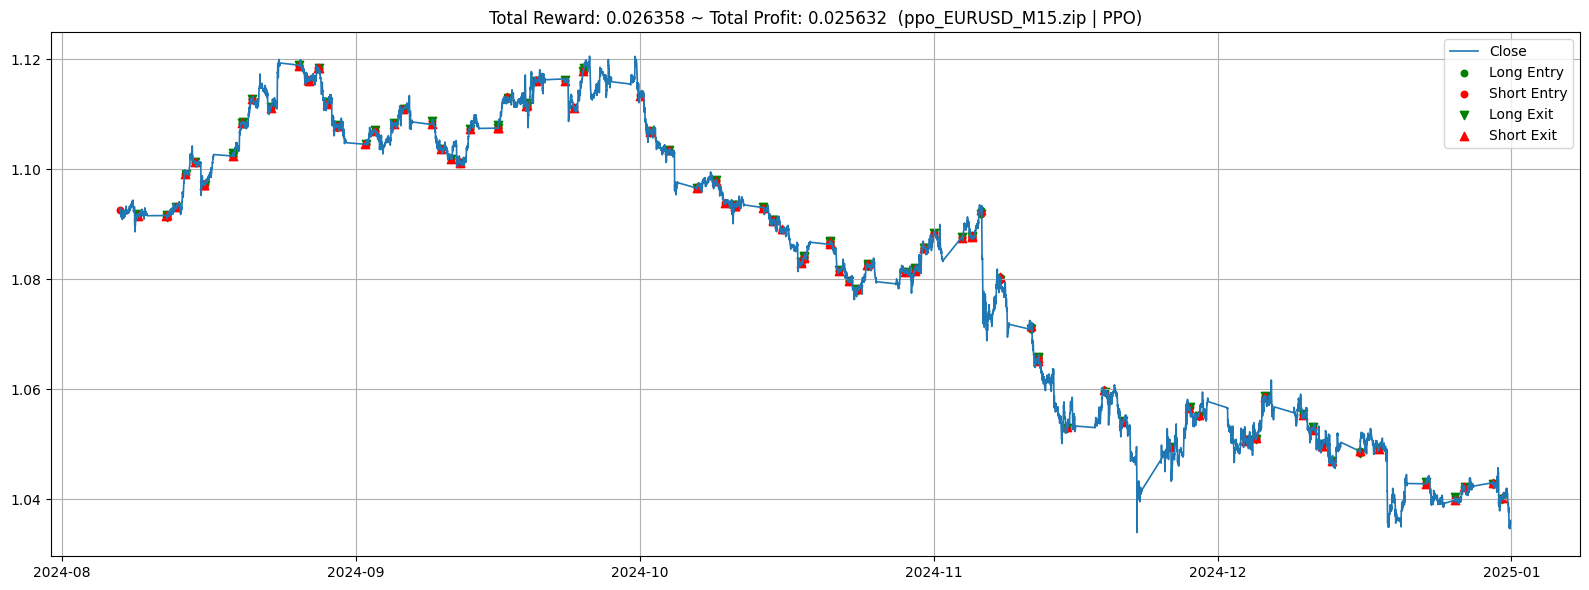

In [10]:
# Uses MODEL_PATH / ALGO_SELECTED from your first block; falls back to auto if not set
try:
    model_name = MODEL_PATH
    algo_hint = ALGO_SELECTED if 'ALGO_SELECTED' in globals() else "auto"
except NameError:
    # If you didn’t run the first block, hardcode a file here:
    model_name = "models/ppo_EURUSD_M15.zip"
    algo_hint = "auto"

pos_series, rewards, model_name_str, algo_used = run_model_collect_series(model_name, algo_hint)
plot_trades_on_price_from_series(df_test, pos_series, rewards, model_name_str, algo_used, save_png=True)


Saved trades plot: G:\My Drive\Github\Deep-Reinforcement-Learning-MT5-Bot\notebooks\reports\trades_ppo_EURUSD_M15.png
Saved trades plot: G:\My Drive\Github\Deep-Reinforcement-Learning-MT5-Bot\notebooks\reports\trades_a2c_EURUSD_M15.png
Saved trades plot: G:\My Drive\Github\Deep-Reinforcement-Learning-MT5-Bot\notebooks\reports\trades_dqn_EURUSD_M15.png


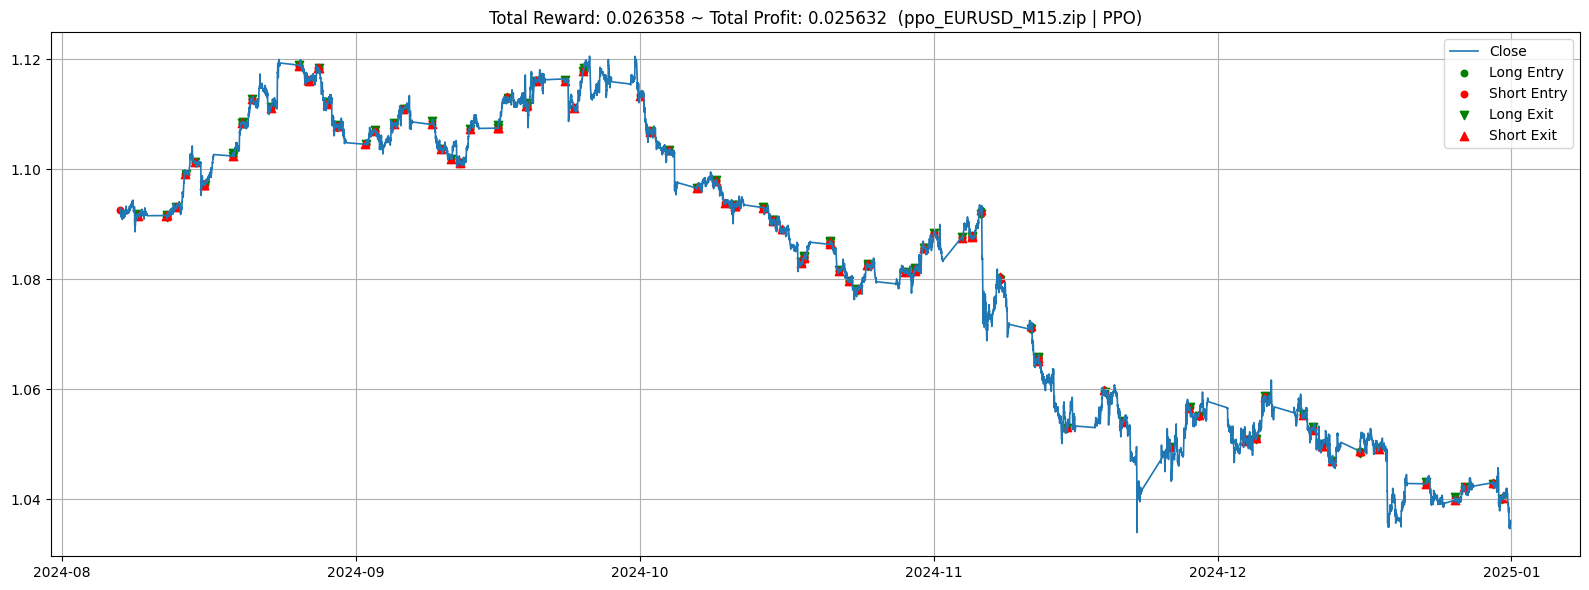

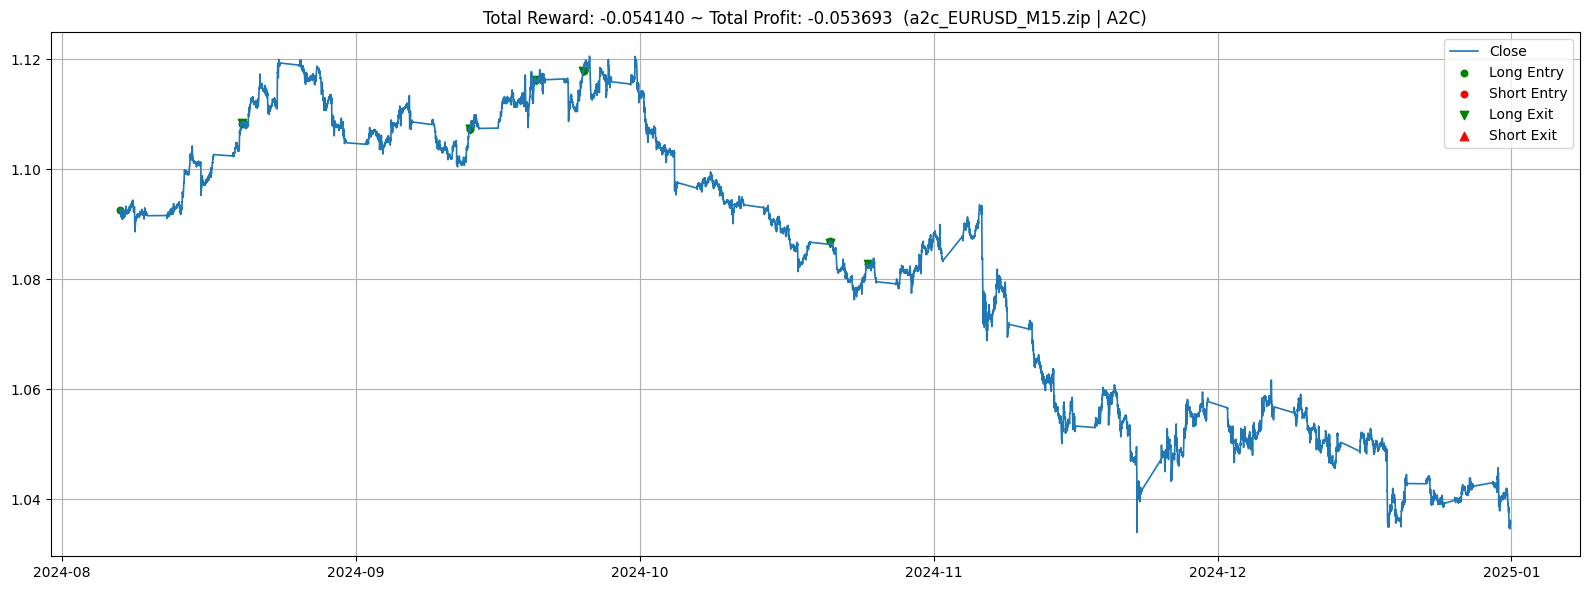

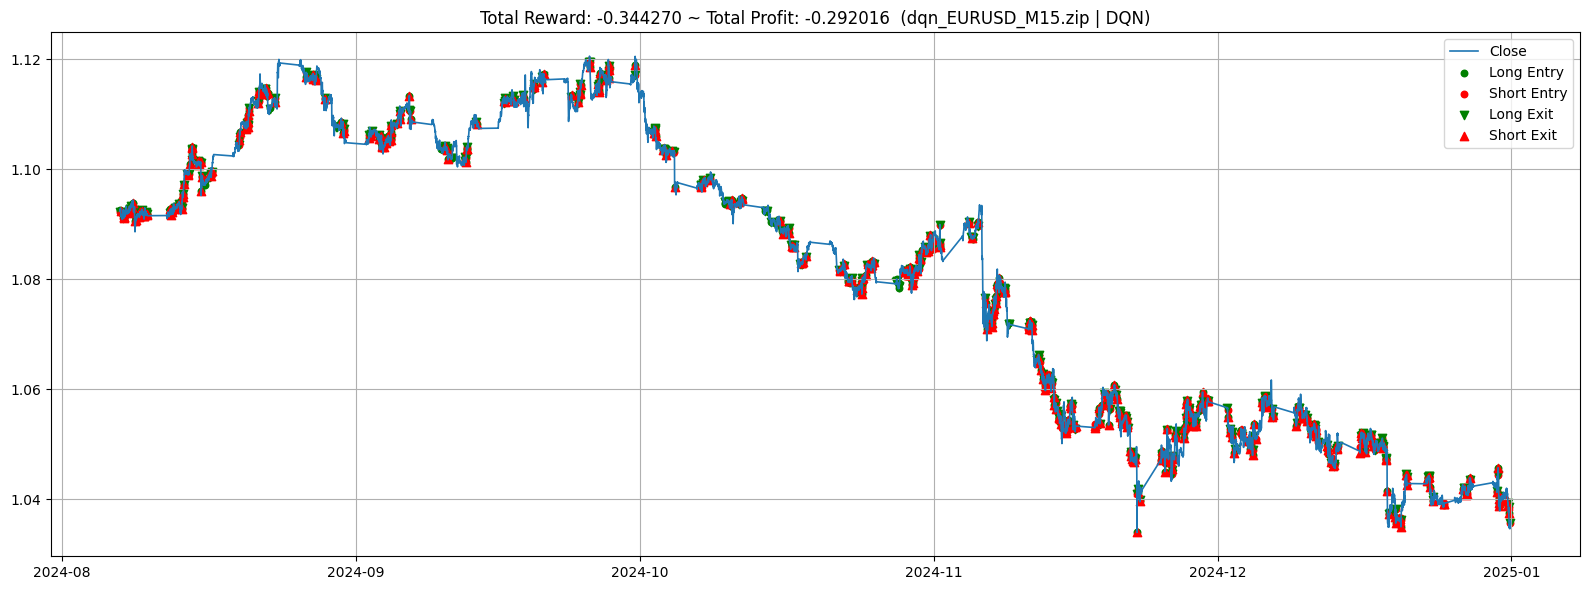

In [11]:
# Requires MODEL_BUNDLE from the earlier “collect models” block
for p, algo in MODEL_BUNDLE:
    pos_series, rewards, model_name_str, algo_used = run_model_collect_series(p, algo)
    plot_trades_on_price_from_series(df_test, pos_series, rewards, model_name_str, algo_used, save_png=True)
